Error loading depression_prevalence.csv: 'utf-8' codec can't decode byte 0xfc in position 28323: invalid start byte
Error loading suicide_rates.csv: 'utf-8' codec can't decode byte 0xfc in position 168394: invalid start byte
Error loading Obesity among adults, BMI = 30 prevalence (crude estimate).csv: 'utf-8' codec can't decode byte 0xfc in position 39758: invalid start byte
Error loading Obesity among adults,BMI = 30 prevalence_age-standardized estimate).csv: [Errno 2] No such file or directory: 'Obesity among adults,BMI = 30 prevalence_age-standardized estimate).csv'
Error loading Overweight among adults, BMI = 25 prevalence (crude estimate).csv: 'utf-8' codec can't decode byte 0xfc in position 109615: invalid start byte
Error loading Overweight among adults, BMI = 25 prevalence (age-standardized estimate).csv: 'utf-8' codec can't decode byte 0xfc in position 17523: invalid start byte
Error loading Underweight among adults, BMI  18.5 prevalence (crude estimate).csv: 'utf-8' codec can

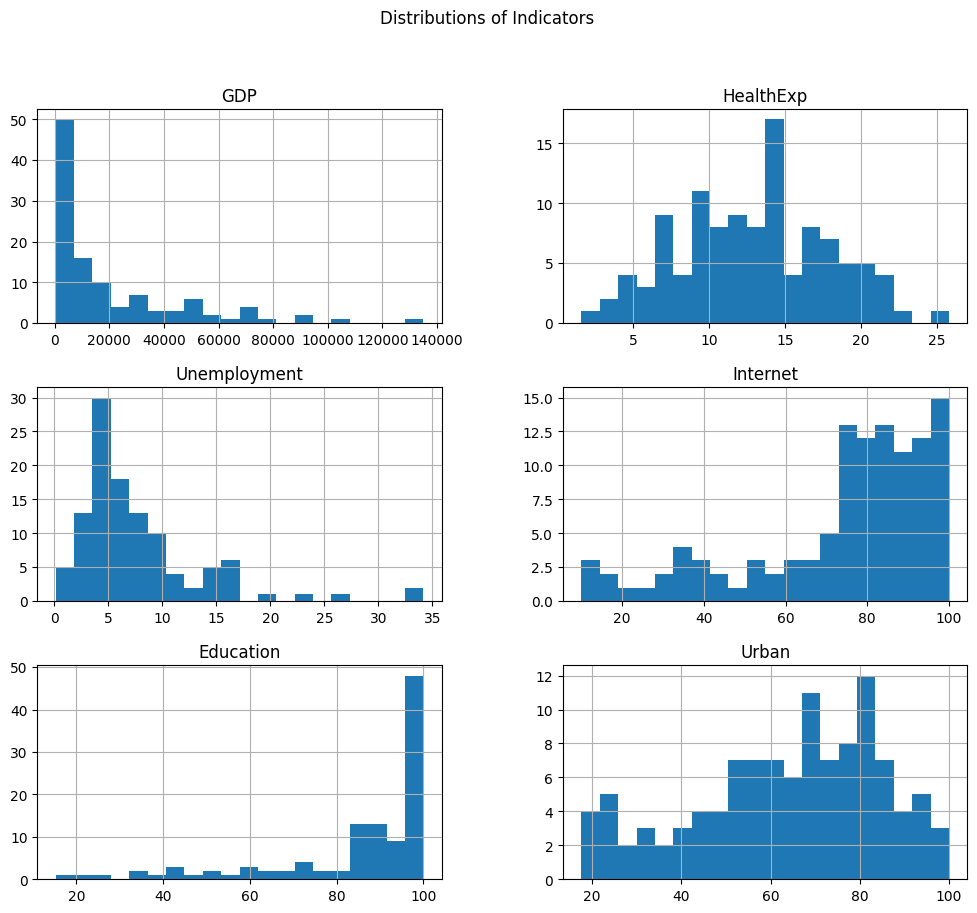

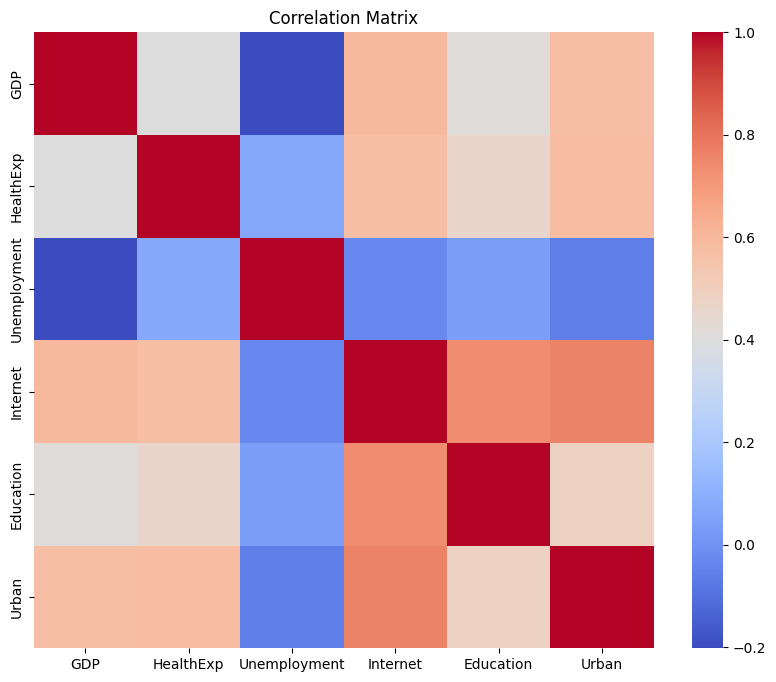

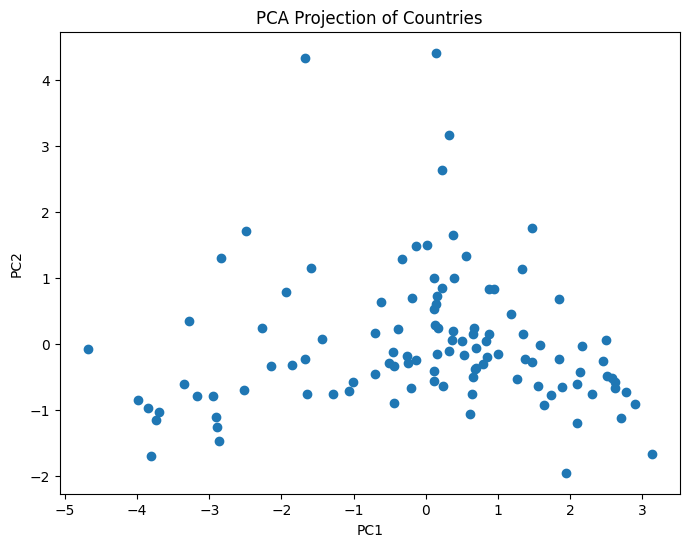

Preprocessing complete. Saved as cleaned_dataset.csv


In [ ]:
# ============================================================== #
# Data Mining Project: Mental Health, Social & Economic Factors  #
# ============================================================== #

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 2. Helper Functions to Load Data

def load_wb_csv(filename, value_col, year="2021", country_col="Country Name"):
    """
    Load World Bank CSVs (with metadata rows).
    Extracts Country and values for a given year.
    """
    try:
        df = pd.read_csv(filename, skiprows=4)
        if year not in df.columns:
            # fallback: take latest available year
            numeric_cols = [c for c in df.columns if c.isdigit()]
            year = numeric_cols[-1]
        df = df[[country_col, year]]
        df.columns = ["Country", value_col]
        df = df.dropna()
        return df
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return pd.DataFrame(columns=["Country", value_col])

def load_who_csv(filename, value_col):
    """
    Load WHO CSVs (with Location, FactValueNumeric).
    Filters for 'Both sexes' and latest year if available.
    """
    try:
        df = pd.read_csv(filename, on_bad_lines='skip')
        if "Location" in df.columns and "FactValueNumeric" in df.columns:
            # optional filters
            if "Dim1" in df.columns:
                df = df[df["Dim1"] == "Both sexes"]
            if "IsLatestYear" in df.columns:
                df = df[df["IsLatestYear"] == True]
            df = df[["Location", "FactValueNumeric"]]
            df.columns = ["Country", value_col]
            df = df.dropna()
            return df
        else:
            print(f" {filename} does not match WHO format, skipping")
            return pd.DataFrame(columns=["Country", value_col])
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return pd.DataFrame(columns=["Country", value_col])

# 3. Load Datasets

# WHO datasets
depression_df = load_who_csv("depression_prevalence.csv", "Depression")
suicide_df = load_who_csv("suicide_rates.csv", "Suicide")

# BMI & Nutrition WHO Datasets
obesity_crude_df = load_who_csv(
    "Obesity among adults, BMI = 30 prevalence (crude estimate).csv","ObesityCrude"
)

obesity_std_df = load_who_csv(
    "Obesity among adults,BMI = 30 prevalence_age-standardized estimate).csv",
    "ObesityStd"
)

overweight_crude_df = load_who_csv(
    "Overweight among adults, BMI = 25 prevalence (crude estimate).csv",
    "OverweightCrude"
)

overweight_std_df = load_who_csv(
    "Overweight among adults, BMI = 25 prevalence (age-standardized estimate).csv",
    "OverweightStd"
)

underweight_crude_df = load_who_csv(
    "Underweight among adults, BMI  18.5 prevalence (crude estimate).csv",
    "UnderweightCrude"
)

underweight_std_df = load_who_csv(
    "Underweight among adults, BMI  18.5 prevalence (age-standardized estimate).csv",
    "UnderweightStd"
)

# World Bank datasets 
gdp_df = load_wb_csv("gdp_per_capita.csv", "GDP", year="2021")
health_exp_df = load_wb_csv("health_expenditure.csv", "HealthExp", year="2021")
internet_df = load_wb_csv("internet_usage.csv", "Internet", year="2021")
education_df = load_wb_csv("education_attainment.csv", "Education", year="2021")
urban_df = load_wb_csv("urban_population.csv", "Urban", year="2021")
unemployment_df = load_wb_csv("unemployment.csv", "Unemployment", year="2021")

# 4. Merge All Datasets
if len(dfs_nonempty) > 1:
    merged = dfs_nonempty[0]
    for df in dfs_nonempty[1:]:
        merged = merged.merge(df, on="Country", how="inner")
    print("Merged dataset shape:", merged.shape)
    print(merged.head())
else:
    print("Not enough non-empty DataFrames to merge.")
    merged = pd.DataFrame()

# 5. Handle Missing Data
# Drop countries with >30% missing
merged = merged.dropna(thresh=int(merged.shape[1]*0.7))
# Fill remaining NaN with median
merged = merged.fillna(merged.median(numeric_only=True))

# 6. Exploratory Data Analysis
# Histograms
merged.hist(figsize=(12, 10), bins=20)
plt.suptitle("Distributions of Indicators")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(merged.drop(columns=["Country"]).corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# 7. Normalize / Standardize
features = merged.drop(columns=["Country"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

X_scaled_df = pd.DataFrame(X_scaled, columns=features.columns)
X_scaled_df["Country"] = merged["Country"].values

# 8. Dimensionality Reduction (PCA)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title("PCA Projection of Countries")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 9. Save Cleaned Dataset
merged.to_csv("cleaned_dataset.csv", index=False)
print("Preprocessing complete. Saved as cleaned_dataset.csv")
